In [751]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For statistical data visualization
import datetime as dt  # For date and time operations
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
#from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler # For scaling the data
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

In [752]:
# 2. Load Dataset
# Read the csv file
# View the first few rows of the dataset
data_path = "../src/dataset/Bitcoin_Historical_Data.csv"
df = pd.read_csv(data_path) 
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-17 00:00:00+00:00,457.334015,457.334015,468.174011,452.421997,465.864014,21056800
1,2014-09-18 00:00:00+00:00,424.440002,424.440002,456.859985,413.104004,456.859985,34483200
2,2014-09-19 00:00:00+00:00,394.795990,394.795990,427.834991,384.532013,424.102997,37919700
3,2014-09-20 00:00:00+00:00,408.903992,408.903992,423.295990,389.882996,394.673004,36863600
4,2014-09-21 00:00:00+00:00,398.821014,398.821014,412.425995,393.181000,408.084991,26580100


In [753]:
# 3. Data Preprocessing
# Convert the 'Date' column to datetime format for easier time series handling
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')

In [754]:
# 4. Feature Engineering
# Extract the year from the 'Date' column and create additional columns
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['dollars'] = df['Close'] * df['Volume']  

In [755]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Year,Month,Day,dollars
0,2014-09-17 00:00:00+00:00,457.334015,457.334015,468.174011,452.421997,465.864014,21056800,2014,9,17,9.629991e+09
1,2014-09-18 00:00:00+00:00,424.440002,424.440002,456.859985,413.104004,456.859985,34483200,2014,9,18,1.463605e+10
2,2014-09-19 00:00:00+00:00,394.795990,394.795990,427.834991,384.532013,424.102997,37919700,2014,9,19,1.497055e+10
3,2014-09-20 00:00:00+00:00,408.903992,408.903992,423.295990,389.882996,394.673004,36863600,2014,9,20,1.507367e+10
4,2014-09-21 00:00:00+00:00,398.821014,398.821014,412.425995,393.181000,408.084991,26580100,2014,9,21,1.060070e+10


In [756]:
# Data Understanding
print("Dataset Info:\n")
df.info()  #Display information about dataset columns and data types

print("\nSummary statistics:\n")
print(df.describe())  # Show summary statistics for numerical columns

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3724 entries, 0 to 3723
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       3724 non-null   datetime64[ns, UTC]
 1   Adj Close  3724 non-null   float64            
 2   Close      3724 non-null   float64            
 3   High       3724 non-null   float64            
 4   Low        3724 non-null   float64            
 5   Open       3724 non-null   float64            
 6   Volume     3724 non-null   int64              
 7   Year       3724 non-null   int32              
 8   Month      3724 non-null   int32              
 9   Day        3724 non-null   int32              
 10  dollars    3724 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int32(3), int64(1)
memory usage: 276.5 KB

Summary statistics:

          Adj Close         Close          High           Low          Open  \
count   3724.00

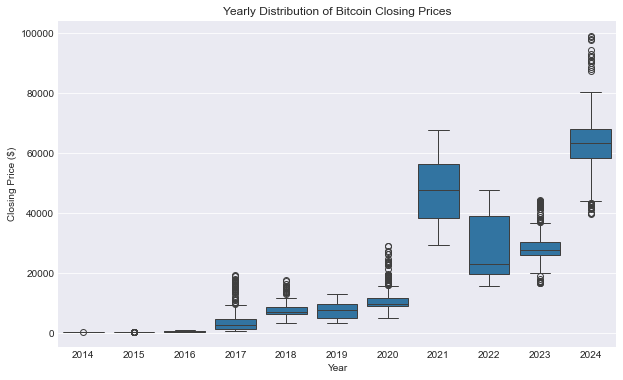

In [757]:
# 5. Exploratory Data Analysis (EDA)
# Visual analysis Boxplot, Line Plot, and Histogram for Bitcoin closing price over time
plt.figure(figsize = (10, 6))
sns.boxplot(data = df, x = 'Year', y = 'Close')
plt.title('Yearly Distribution of Bitcoin Closing Prices')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
plt.show()

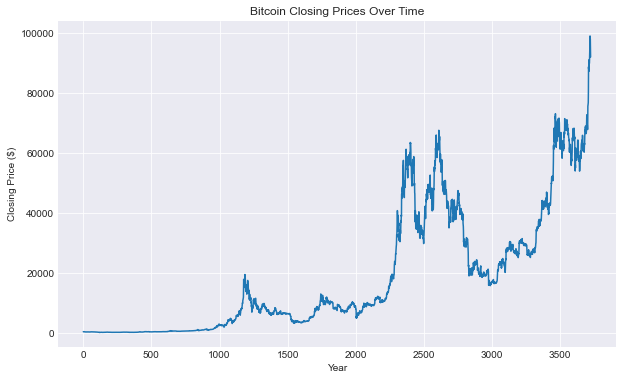

In [758]:
plt.figure(figsize=(10,6))
df['Close'].plot()  # Line plot for the closing prices over time
plt.title("Bitcoin Closing Prices Over Time")
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
plt.show()

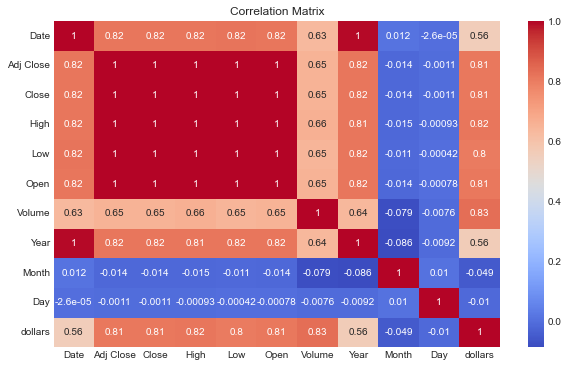

In [759]:
# 6. Correlation Analysis
# Display a correlation matrix for feature relationships
correlation_matrix = df.corr()
plt.figure(figsize = (10, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm') # Correlation heatmap
plt.title('Correlation Matrix')
plt.show()

In [760]:
# 7. Data Preprocessing for Model Training
# Extract the 'Close' price as the target variable
data = df.filter(['Close'])
dataset = data.values

In [761]:
# Split the data into training and test sets ( 95% train, 5% test)
train_size = int(np.ceil(len(dataset) * .95))
train_size

3538

In [762]:
# Scale the data using MinMaxScaler to normalize values between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00282567],
       [0.0024928 ],
       [0.00219281],
       ...,
       [0.99004404],
       [0.9403421 ],
       [0.92903891]])

In [763]:
# 8. Time Series Window Creation
# Create windows for training the model
# Create the scaled training and test dataset 
# Split the data into training and test sets ( 95% train, 5% test)
train_data = scaled_data[0: int(train_size), :]
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60: i, 0])  # Input sequence of time_step length
    y_train.append(train_data[i, 0])  # Target (next day's closing price)
    if i <= 61:
        print(X_train)
        print(y_train)
        print()

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping Data
# Reshape the input data to be compatible with the LSTM model
# LSTM expects inputs in the form [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

[array([0.00282567, 0.0024928 , 0.00219281, 0.00233558, 0.00223355,
       0.00226725, 0.00260766, 0.0024803 , 0.0023626 , 0.00229025,
       0.00224062, 0.00201456, 0.00199722, 0.00211336, 0.00207967,
       0.00199322, 0.00183576, 0.00152564, 0.00144108, 0.00153791,
       0.00159972, 0.00176926, 0.00189156, 0.00185651, 0.00186396,
       0.0020284 , 0.00214847, 0.00225428, 0.00219258, 0.00206895,
       0.00208112, 0.00215887, 0.00213969, 0.00207188, 0.00210861,
       0.00207504, 0.00182468, 0.00182395, 0.00171189, 0.00178711,
       0.00176975, 0.00181659, 0.00159369, 0.00169199, 0.00162132,
       0.0014941 , 0.00149554, 0.00151236, 0.00154209, 0.00163311,
       0.00173232, 0.00166275, 0.00169384, 0.00187373, 0.00191077,
       0.00191857, 0.0024839 , 0.0024553 , 0.0022234 , 0.00200396])]
[0.0021228488513504243]

[array([0.00282567, 0.0024928 , 0.00219281, 0.00233558, 0.00223355,
       0.00226725, 0.00260766, 0.0024803 , 0.0023626 , 0.00229025,
       0.00224062, 0.00201456, 0.

In [764]:
# Model-1: LSTM Model
model = Sequential()
# Add LSTM layer: The first LSTM layer with 50 units, input shape as the reshaped X_train
model.add(LSTM(units = 128, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Add another LSTM layer: A secon LSTM layer
model.add(LSTM(units = 64, return_sequences = False))
# Add Dense Layer: The fully connected layer to output a single value (predicted price)
model.add(Dense(1))
model.add(Dense(units = 25))

In [765]:
# Compile the model
# Specify the optimizer and loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Train the model using the training data
model.fit(X_train, y_train, epochs = 2, batch_size = 1)

Epoch 1/2
3478/3478 [==============================] - 80s 22ms/step - loss: 0.0059
Epoch 2/2
3478/3478 [==============================] - 75s 21ms/step - loss: 2.7462e-04


In [766]:
# Create the scaled testing dataset
test_data = scaled_data[train_size - 60: , :]
X_test = []
y_test = dataset[train_size: , :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60: i, 0])  # Input sequence of time_step length

X_test = np.array(X_test)

In [767]:
# Reshaping Data
# Reshape the input data to be compatible with the LSTM model
# LSTM expects inputs in the form [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

In [768]:
# Evaluate the model on the test data
predictions = model.predict(X_test)
# Convert the scaled predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

6/6 [==============================] - 1s 17ms/step


In [769]:
# Evaluate the model
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 2594.772709190552


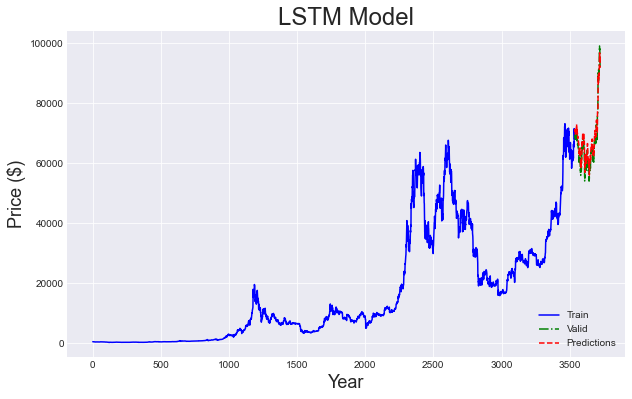

In [770]:
# Visualizing predictions vs actual values
train = data[:train_size]

valid = data[train_size:]

# Create a DataFrame from predictions
predictions_df = pd.DataFrame(predictions, index=valid.index, columns=[f'Prediction_{i}' for i in range(predictions.shape[1])])

# Concatenate with the valid DataFrame
valid = pd.concat([valid, predictions_df], axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.title('LSTM Model', fontsize=24)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Price ($)', fontsize=18)

# Plot actual values for train data
plt.plot(train['Close'], label="Actual Prices", color='blue')

# Plot actual values for valid data
plt.plot(valid['Close'], label="Actual Prices - Validation", color='green', linestyle='-.')

# Plot predicted values for valid data (modify this to the correct prediction column)
plt.plot(valid['Prediction_0'], label="Predicted Prices", color='red', linestyle='--')

# Add a legend for clarity
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')

# Show the plot
plt.show()


In [771]:
# Model-2: AutoRegressive Integrated Moving Average (ARIMA)
# Perform Augumented Dickey-Fuller test
adf_result = adfuller(df['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: 0.26653446543854886
p-value: 0.9757559219194227


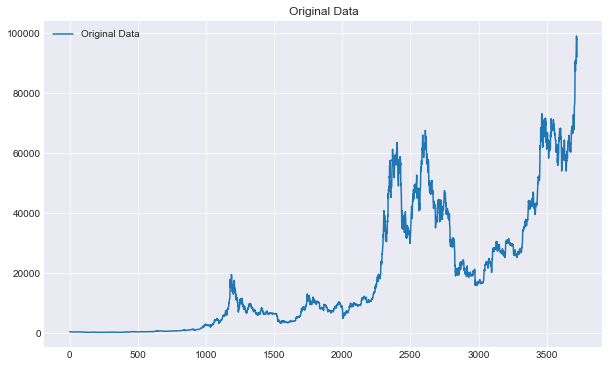

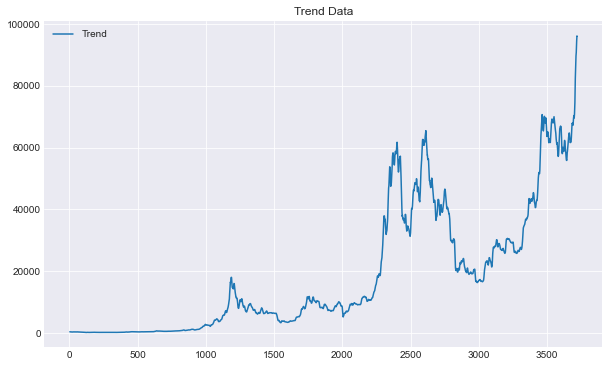

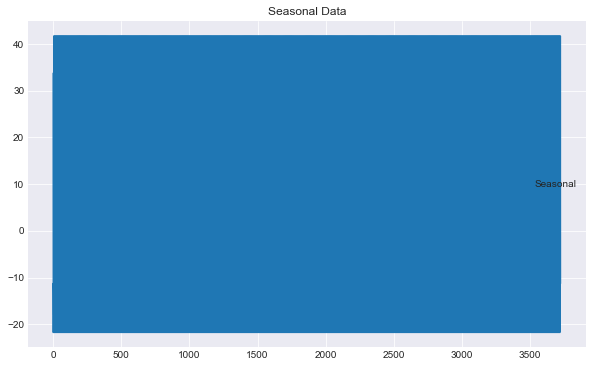

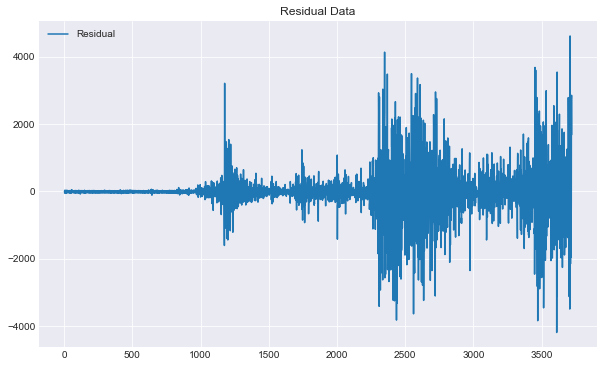

In [772]:
# Visualize Original Data
plt.figure()
plt.plot(df.index.to_numpy(), df['Close'].values)  # Convert both to numpy arrays
plt.legend(['Original Data'])
plt.title('Original Data')
plt.show()

# Visualize Trend Data
plt.figure()
plt.plot(df.index.to_numpy(), decomposition.trend.values)  # Convert to 1D array
plt.legend(['Trend'])
plt.title('Trend Data')
plt.show()

# Visualize Seasonal Data
plt.figure()
plt.plot(df.index.to_numpy(), decomposition.seasonal.values)  # Convert to 1D array
plt.legend(['Seasonal'])
plt.title('Seasonal Data')
plt.show()

# Visualize Residual Data
plt.figure()
plt.plot(df.index.to_numpy(), decomposition.resid.values)  # Convert to 1D array
plt.legend(['Residual'])
plt.title('Residual Data')
plt.show()


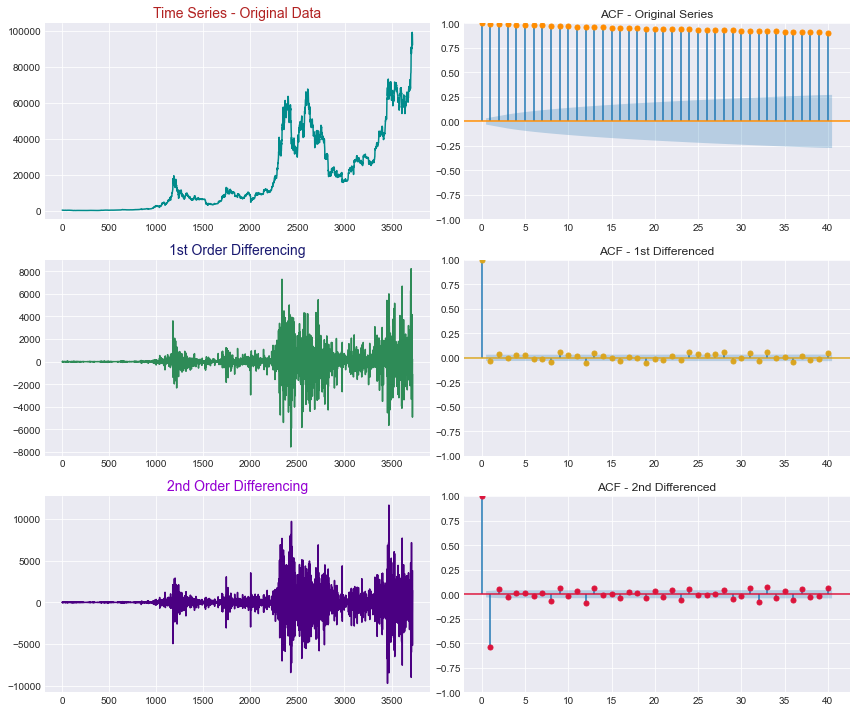

In [773]:
# Since the data is not stationary we need to diffrencing
# Set custom style for better visuals
plt.style.use('seaborn-darkgrid')

# Step 1: Create subplots for original series and differencing
fig, axes = plt.subplots(3, 2, figsize = (12, 10), sharex = False)

# Step 2: Plot the original series on the first subplot
axes[0, 0].plot(df['Close'], color = 'darkcyan')  # Changed color to dark cyan
axes[0, 0].set_title('Time Series - Original Data', fontsize = 14, color = 'firebrick')  # Changed title and color

# Step 3: Plot the ACF of the original series
plot_acf(df['Close'], ax = axes[0, 1], lags = 40, color = 'darkorange', title = 'ACF - Original Series')  # Changed color to dark orange

# Step 4: Plot the first differenced series on the second subplot
axes[1, 0].plot(df['Close'].diff(), color = 'seagreen')  # Changed color to seagreen
axes[1, 0].set_title('1st Order Differencing', fontsize = 14, color = 'midnightblue')  # Changed title and color

# Step 5: Plot the ACF of the first differenced series
plot_acf(df['Close'].diff().dropna(), ax = axes[1, 1], lags = 40, color = 'goldenrod', title = 'ACF - 1st Differenced')  # Changed color to goldenrod

# Step 6: Plot the second differenced series on the third subplot
axes[2, 0].plot(df['Close'].diff().diff(), color = 'indigo')  # Changed color to indigo
axes[2, 0].set_title('2nd Order Differencing', fontsize = 14, color = 'darkviolet')  # Changed title and color

# Step 7: Plot the ACF of the second differenced series
plot_acf(df['Close'].diff().diff().dropna(), ax = axes[2, 1], lags = 40, color = 'crimson', title = 'ACF - 2nd Differenced')  # Changed color to crimson

# Step 8: Adjust layout and show the plot
plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()  # Display the plot


In [774]:
# Train-test split for ARIMA model ( 95% train, 5% test)
train_data = dataset[: train_size, :]
test_data = dataset[train_size: , 0]


In [775]:
# ARIMA model parameters (p, d, q) 
arima_model= ARIMA(train, order = (2,1,2))
arima_model_fit = arima_model.fit()

In [776]:
# Forecast with ARIMA model
forecast_steps = len(test_data)
arima_forecast = arima_model_fit.forecast(steps = forecast_steps)

In [777]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data, arima_forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 9652.537731755529


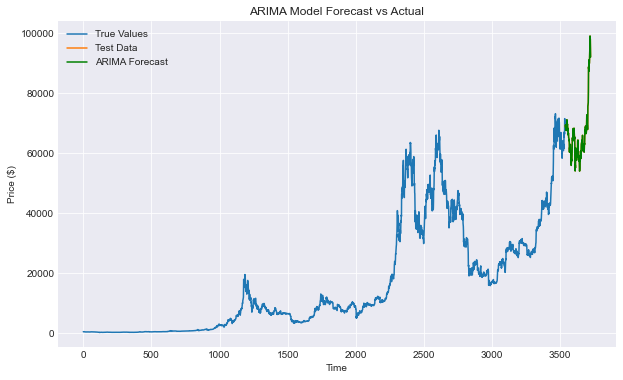

In [746]:
# Plot the ARIMA model forecast
plt.figure(figsize = (10, 6))
plt.plot(range(len(train_data)), train_data, label='True Values')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='ARIMA Forecast', color='green')
plt.title("ARIMA Model Forecast vs Actual Prices")
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [747]:
# Model -3: SARIMA Model
# SARIMA model parameters (p, d, q) and (P, D, Q, S)
sarima_model= SARIMAX(train, order = (2,1,2), seasonal_order = (1, 1, 1, 12), enforce_stationarity = False, 
                      enforce_invertibility = False)
sarima_model_fit = sarima_model.fit()

In [748]:
# Forecast with SARIMA model
forecast_steps = len(test_data)
sarima_forecast = sarima_model_fit.forecast(steps = forecast_steps)

In [749]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 10035.62713195005


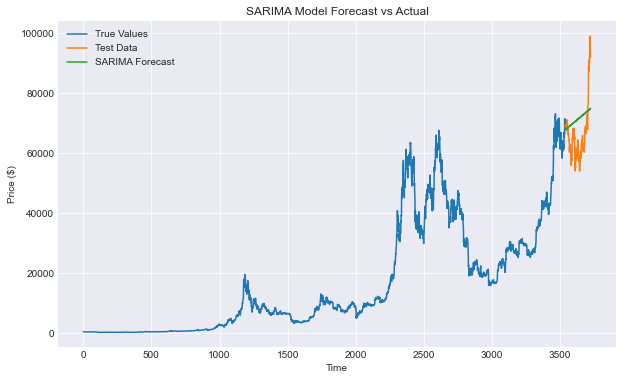

In [750]:
# Ensure both train_data and forecast are numpy arrays and plot them
plt.figure(figsize=(10, 6))

# Directly plot train_data as it's a numpy array
plt.plot(range(len(train_data)), train_data, label='True Values')

plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='Test Data')

# Convert test data to the correct range for the forecast plot
forecast_range = range(len(train_data), len(train_data) + len(test_data))

# Ensure sarima_forecast is a 1D array and plot it
plt.plot(forecast_range, np.array(sarima_forecast).flatten(), label='SARIMA Forecast')

plt.title("SARIMA Model Forecast vs Actual Prices")
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend()
plt.show()
